In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (seq_len, batch, d_model)
        return x + self.pe[:x.size(0), :]

class GatedMemoryModule(nn.Module):
    def __init__(self, n_memory_items, memory_dim, temperature=0.1):
        super(GatedMemoryModule, self).__init__()
        self.n_memory_items = n_memory_items
        self.memory_dim = memory_dim
        self.temperature = temperature

        # 初始化記憶項目
        self.memory_items = nn.Parameter(
            torch.randn(n_memory_items, memory_dim) * 0.1
        )

        # 門控更新的線性投影
        self.U_psi = nn.Linear(memory_dim, memory_dim, bias=False)
        self.W_psi = nn.Linear(memory_dim, memory_dim, bias=False)

    def forward(self, queries, training=True):
        """
        queries: (seq_len, batch, memory_dim)
        返回: updated_queries (seq_len, batch, 2*memory_dim)
        """
        seq_len, batch_size, _ = queries.shape

        if training:
            # 階段1: 記憶項目更新
            self._update_memory_items(queries)

        # 階段2: 查詢更新
        updated_queries = self._update_queries(queries)

        return updated_queries

    def _compute_query_conditioned_attention(self, queries, memory_items):
        """
        計算query-conditioned memory attention (論文公式1)
        對每個記憶項目i，計算它與所有時間步查詢的注意力權重
        """
        seq_len, batch_size, _ = queries.shape
        v_attention = torch.zeros(batch_size, self.n_memory_items, seq_len).to(queries.device)

        # 對每個記憶項目分別計算注意力權重
        for i in range(self.n_memory_items):
            # 計算記憶項目i與所有時間步查詢的分數
            scores = torch.matmul(queries, memory_items[i].unsqueeze(-1)).squeeze(-1)  # (seq_len, batch)
            scores = scores / self.temperature

            # 對時間維度進行softmax (這是關鍵修正!)
            v_attention[:, i, :] = F.softmax(scores.transpose(0, 1), dim=-1)  # (batch, seq_len)

        return v_attention.transpose(1, 2)  # (batch, seq_len, n_memory_items)

    def _compute_memory_conditioned_attention(self, queries, memory_items):
        """
        計算memory-conditioned query attention (論文公式4)
        對每個查詢，計算它與所有記憶項目的注意力權重
        """
        # queries: (seq_len, batch, memory_dim)
        # memory_items: (n_memory_items, memory_dim)

        scores = torch.matmul(queries, memory_items.t()) / self.temperature
        # scores: (seq_len, batch, n_memory_items)

        # 對記憶項目維度進行softmax
        return F.softmax(scores, dim=-1)

    def _update_memory_items(self, queries):
        """更新記憶項目（僅在訓練時）"""
        seq_len, batch_size, _ = queries.shape

        # 修正: 使用正確的query-conditioned attention計算
        v_attention = self._compute_query_conditioned_attention(queries, self.memory_items)
        # v_attention: (batch, seq_len, n_memory_items)

        # 對每個記憶項目進行更新
        for i in range(self.n_memory_items):
            # 提取當前記憶項目的注意力權重
            v_i = v_attention[:, :, i]  # (batch, seq_len)

            # 計算加權查詢向量 (論文公式2中的求和項)
            # Σ_{t=1}^L v^s_{i,t} q^s_t
            weighted_sum = torch.sum(
                v_i.unsqueeze(-1) * queries.transpose(0, 1), dim=1  # (batch, memory_dim)
            )

            # 對批次求平均
            weighted_queries = weighted_sum.mean(dim=0)  # (memory_dim,)

            # 確保設備一致性
            weighted_queries = weighted_queries.to(self.memory_items.device)

            # 計算更新門控 (論文公式2)
            # ψ = σ(U_ψm_i + W_ψ∑_{t=1}^L v^s_{i,t}q^s_t)
            gate_input = (self.U_psi(self.memory_items[i]) +
                         self.W_psi(weighted_queries))
            update_gate = torch.sigmoid(gate_input)

            # 更新記憶項目 (論文公式3)
            # m_i ← (1-ψ)◦m_i + ψ◦∑_{t=1}^L v^s_{i,t}q^s_t
            with torch.no_grad():
                self.memory_items.data[i] = (
                    (1 - update_gate) * self.memory_items[i] +
                    update_gate * weighted_queries
                )

    def _update_queries(self, queries):
        """更新查詢向量"""
        # 使用正確的memory-conditioned attention計算
        w_attention = self._compute_memory_conditioned_attention(queries, self.memory_items)
        # w_attention: (seq_len, batch, n_memory_items)

        # 檢索記憶項目 (論文公式5)
        # q̃^s_t = ∑_{i'=1}^M w^s_{t,i'}m_{i'}
        retrieved_memory = torch.matmul(w_attention, self.memory_items)
        # retrieved_memory: (seq_len, batch, memory_dim)

        # 連接查詢和檢索的記憶
        updated_queries = torch.cat([queries, retrieved_memory], dim=-1)
        # updated_queries: (seq_len, batch, 2*memory_dim)

        return updated_queries

class MEMTO(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=3,
                 n_memory_items=10, temperature=0.1, dropout=0.1):
        super(MEMTO, self).__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.n_memory_items = n_memory_items
        self.temperature = temperature

        # 輸入投影
        self.input_projection = nn.Linear(input_dim, d_model)

        # 位置編碼
        self.pos_encoding = PositionalEncoding(d_model)

        # Transformer編碼器
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4*d_model,
            dropout=dropout,
            batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # 門控記憶模組
        self.gated_memory = GatedMemoryModule(
            n_memory_items=n_memory_items,
            memory_dim=d_model,
            temperature=temperature
        )

        # 弱解碼器（兩層全連接）
        self.decoder = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, input_dim)
        )

        # 熵損失權重
        self.entropy_weight = 0.01

    def forward(self, x, training=True):
        """
        x: (seq_len, batch, input_dim)
        返回: 重構結果, 查詢特徵, 記憶注意力權重
        """
        # 驗證輸入維度
        assert x.size(-1) == self.input_dim, f"輸入維度不匹配: 期望{self.input_dim}, 實際{x.size(-1)}"

        # 輸入投影
        x_proj = self.input_projection(x)

        # 位置編碼
        x_pos = self.pos_encoding(x_proj)

        # Transformer編碼
        queries = self.transformer_encoder(x_pos)

        # 門控記憶處理
        updated_queries = self.gated_memory(queries, training=training)

        # 解碼重構
        reconstruction = self.decoder(updated_queries)

        # 驗證輸出維度
        assert reconstruction.shape == x.shape, f"重構維度不匹配: 輸入{x.shape}, 重構{reconstruction.shape}"

        # 計算注意力權重用於異常檢測
        attention_weights = self._compute_attention_weights(queries)

        return reconstruction, queries, attention_weights

    def _compute_attention_weights(self, queries):
        """計算用於異常檢測的注意力權重"""
        with torch.no_grad():
            scores = torch.matmul(queries, self.gated_memory.memory_items.t()) / self.temperature
            attention_weights = F.softmax(scores, dim=-1)
        return attention_weights

    def compute_loss(self, x, reconstruction, attention_weights):
        """計算總損失"""
        # 確保維度一致
        assert x.shape == reconstruction.shape, f"損失計算時維度不匹配: x{x.shape}, recon{reconstruction.shape}"

        # 重構損失
        reconstruction_loss = F.mse_loss(reconstruction, x)

        # 熵損失（稀疏性正則化）
        entropy_loss = -torch.mean(
            torch.sum(attention_weights * torch.log(attention_weights + 1e-8), dim=-1)
        )

        total_loss = reconstruction_loss + self.entropy_weight * entropy_loss

        return total_loss, reconstruction_loss, entropy_loss

class MEMTOAgent:
    def __init__(self, input_dim, window_size=100, n_states=1, k_per_state=10, **model_kwargs):
        self.input_dim = input_dim
        self.window_size = window_size
        self.n_states = n_states
        self.k_per_state = k_per_state
        n_memory_items = n_states * k_per_state
        model_kwargs['n_memory_items'] = n_memory_items
        self.model_kwargs = model_kwargs
        self.variance_loss_weight = 0.1

        # 初始化模型
        self.model = MEMTO(input_dim=input_dim, **model_kwargs)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # 優化器
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=5e-5)

        # 訓練歷史
        self.training_history = {
            'total_loss': [],
            'reconstruction_loss': [],
            'entropy_loss': []
        }

        print(f"模型初始化完成，設備: {self.device}")
        print(f"輸入維度: {input_dim}, 窗口大小: {window_size}")
        print(f"狀態數: {n_states}, 每狀態記憶數: {k_per_state}, 總記憶數: {n_memory_items}")

    def _create_windows(self, data, states):
        """創建滑動窗口"""
        if len(data.shape) == 1:
            data = data.reshape(-1, 1)

        n_samples, n_features = data.shape
        if n_samples < self.window_size:
            raise ValueError(f"數據長度 {n_samples} 小於窗口大小 {self.window_size}")

        # 確保特徵維度匹配
        if n_features != self.input_dim:
            raise ValueError(f"數據特徵維度 {n_features} 與模型輸入維度 {self.input_dim} 不匹配")
        if len(states) != n_samples:
            raise ValueError(f"狀態長度 {len(states)} 與數據長度 {n_samples} 不匹配")

        # 非重疊滑動窗口
        n_windows = n_samples // self.window_size
        windows = []
        state_windows = []

        for i in range(n_windows):
            start_idx = i * self.window_size
            end_idx = start_idx + self.window_size
            window = data[start_idx:end_idx]
            state_window = states[start_idx:end_idx]
            windows.append(window)
            state_windows.append(state_window)

        return np.array(windows), np.array(state_windows)

    def _initialize_memory_with_kmeans(self, data, data_states):
        """修正: 實現完整的K-means初始化過程 (論文Algorithm 1)"""
        print("正在使用K-means初始化記憶項目...")

        # 創建窗口
        windows, state_windows = self._create_windows(data, data_states)

        # 隨機采樣10%的數據 (論文中提到的)
        n_samples = len(windows)
        sample_size = max(1, int(0.1 * n_samples))
        sampled_indices = np.random.choice(n_samples, sample_size, replace=False)
        sampled_windows = windows[sampled_indices]
        sampled_state_windows = state_windows[sampled_indices]

        # 轉換為tensor並獲取查詢特徵
        sampled_tensor = torch.FloatTensor(sampled_windows).to(self.device)
        sampled_tensor = sampled_tensor.transpose(0, 1)  # (seq_len, batch, input_dim)

        self.model.eval()
        with torch.no_grad():
            # 只通過encoder部分獲取查詢特徵
            x_proj = self.model.input_projection(sampled_tensor)
            x_pos = self.model.pos_encoding(x_proj)
            queries = self.model.transformer_encoder(x_pos)

            # 將查詢特徵展平用於聚類 (qrand ∈ R^{T×C}, where T = Nrand × L)
            queries_flat = queries.view(-1, queries.size(-1)).cpu().numpy()
            states_flat = sampled_state_windows.reshape(-1)

        all_centroids = []
        for state_id in range(self.n_states):
            state_mask = (states_flat == state_id)
            queries_for_state = queries_flat[state_mask]
            
            print(f"正在為狀態 {state_id} 聚類，樣本數: {len(queries_for_state)}")
            if len(queries_for_state) < self.k_per_state:
                print(f"  警告: 樣本數不足，將使用隨機採樣填充聚類中心。")
                if len(queries_for_state) > 0:
                    random_indices = np.random.choice(len(queries_for_state), self.k_per_state, replace=True)
                    centroids_for_state = queries_for_state[random_indices]
                else:
                    centroids_for_state = np.random.randn(self.k_per_state, self.model.d_model) * 0.1
            else:
                # K-means聚類獲取k_per_state個聚類中心
                kmeans = KMeans(n_clusters=self.k_per_state, random_state=42, n_init=10)
                kmeans.fit(queries_for_state)
                centroids_for_state = kmeans.cluster_centers_
            
            all_centroids.append(centroids_for_state)

        # 用聚類中心初始化記憶項目 (mi = ci)
        centroids = np.concatenate(all_centroids, axis=0)
        self.model.gated_memory.memory_items.data = torch.FloatTensor(centroids).to(self.device)

        print(f"記憶項目已使用按狀態K-means初始化 (總聚類數: {len(centroids)})")
        return centroids

    def train(self, data, states, epochs=50, validation_split=0.2, patience=10, verbose=True):
        """
        修正: 實現完整的兩階段訓練範式

        第一階段：預訓練encoder
        第二階段：K-means初始化記憶項目
        第三階段：完整端到端訓練
        """
        print(f"開始MEMTO兩階段訓練...")
        print(f"數據形狀: {data.shape}")
        print(f"狀態形狀: {states.shape}")
        print(f"窗口大小: {self.window_size}")

        # 準備數據
        windows, state_windows = self._create_windows(data, states)
        n_train = int(len(windows) * (1 - validation_split))
        train_windows, train_states = windows[:n_train], state_windows[:n_train]
        val_windows, val_states = windows[n_train:], state_windows[n_train:]

        train_dataset = torch.FloatTensor(train_windows)
        val_dataset = torch.FloatTensor(val_windows)

        print(f"訓練集窗口數: {len(train_windows)}, 驗證集窗口數: {len(val_windows)}")

        # === 第一階段：預訓練Encoder ===
        print("\n=== 第一階段：預訓練Encoder ===")
        self._pretrain_encoder(train_dataset, train_states, val_dataset, val_states, epochs=epochs//2, verbose=verbose)

        # === 第二階段：K-means初始化記憶項目 ===
        print("\n=== 第二階段：K-means初始化記憶項目 ===")
        self._initialize_memory_with_kmeans(data, states)

        # === 第三階段：完整端到端訓練 ===
        print("\n=== 第三階段：完整端到端訓練 ===")
        self._full_training(train_dataset, val_dataset, epochs=epochs, patience=patience, verbose=verbose)

        return self.training_history

    def _pretrain_encoder(self, train_dataset, train_states, val_dataset, val_states, epochs, verbose):
        """第一階段：預訓練encoder"""
        # 創建臨時解碼器用於預訓練
        temp_decoder = nn.Linear(self.model.d_model, self.input_dim).to(self.device)
        temp_optimizer = torch.optim.Adam(
            list(self.model.input_projection.parameters()) +
            list(self.model.transformer_encoder.parameters()) +
            list(temp_decoder.parameters()),
            lr=5e-5
        )

        best_val_loss = float('inf')

        for epoch in range(epochs):
            # 訓練
            self.model.train()
            temp_decoder.train()

            batch_data = train_dataset.to(self.device)
            batch_states = torch.LongTensor(train_states).to(self.device)
            batch_data = batch_data.transpose(0, 1)  # (seq_len, batch, input_dim)
            batch_states = batch_states.transpose(0, 1)

            temp_optimizer.zero_grad()

            # 只使用encoder+臨時decoder
            x_proj = self.model.input_projection(batch_data)
            x_pos = self.model.pos_encoding(x_proj)
            queries = self.model.transformer_encoder(x_pos)
            reconstruction = temp_decoder(queries)

            mse_loss = F.mse_loss(reconstruction, batch_data)
            
            queries_flat = queries.reshape(-1, queries.size(-1))
            states_flat = batch_states.reshape(-1)
            intra_state_variance_loss = 0
            
            for state_id in range(self.n_states):
                state_mask = (states_flat == state_id)
                if state_mask.sum() > 1:
                    queries_for_state = queries_flat[state_mask]
                    variance = torch.var(queries_for_state, dim=0).mean()
                    intra_state_variance_loss += variance
            
            loss = mse_loss + self.variance_loss_weight * (intra_state_variance_loss / self.n_states)
            loss.backward()
            temp_optimizer.step()

            # 驗證
            self.model.eval()
            temp_decoder.eval()
            with torch.no_grad():
                val_batch_data = val_dataset.to(self.device)
                val_batch_states = torch.LongTensor(val_states).to(self.device)
                val_batch_data = val_batch_data.transpose(0, 1)
                val_batch_states = val_batch_states.transpose(0, 1)

                val_x_proj = self.model.input_projection(val_batch_data)
                val_x_pos = self.model.pos_encoding(val_x_proj)
                val_queries = self.model.transformer_encoder(val_x_pos)
                val_reconstruction = temp_decoder(val_queries)

                val_mse_loss = F.mse_loss(val_reconstruction, val_batch_data)
                
                val_queries_flat = val_queries.reshape(-1, val_queries.size(-1))
                val_states_flat = val_batch_states.reshape(-1)
                val_intra_state_variance_loss = 0
                for state_id in range(self.n_states):
                    state_mask = (val_states_flat == state_id)
                    if state_mask.sum() > 1:
                        queries_for_state = val_queries_flat[state_mask]
                        variance = torch.var(queries_for_state, dim=0).mean()
                        val_intra_state_variance_loss += variance

                val_loss = val_mse_loss + self.variance_loss_weight * (val_intra_state_variance_loss / self.n_states)

            if val_loss < best_val_loss:
                best_val_loss = val_loss

            if verbose and epoch % 10 == 0:
                print(f"預訓練 Epoch {epoch+1}/{epochs}, 訓練損失: {loss.item():.6f}, 驗證損失: {val_loss.item():.6f}")

        print(f"預訓練完成，最佳驗證損失: {best_val_loss:.6f}")

    def _full_training(self, train_dataset, val_dataset, epochs, patience, verbose):
        """第三階段：完整端到端訓練"""
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            # 訓練階段
            self.model.train()

            batch_data = train_dataset.to(self.device)
            batch_data = batch_data.transpose(0, 1)  # (seq_len, batch, input_dim)

            self.optimizer.zero_grad()

            reconstruction, queries, attention_weights = self.model(batch_data, training=True)
            total_loss, recon_loss, entropy_loss = self.model.compute_loss(
                batch_data, reconstruction, attention_weights
            )

            total_loss.backward()
            self.optimizer.step()

            # 驗證階段
            self.model.eval()
            with torch.no_grad():
                val_batch_data = val_dataset.to(self.device)
                val_batch_data = val_batch_data.transpose(0, 1)

                val_reconstruction, val_queries, val_attention_weights = self.model(
                    val_batch_data, training=False
                )
                val_total_loss, val_recon_loss, val_entropy_loss = self.model.compute_loss(
                    val_batch_data, val_reconstruction, val_attention_weights
                )

            # 記錄歷史
            self.training_history['total_loss'].append(total_loss.item())
            self.training_history['reconstruction_loss'].append(recon_loss.item())
            self.training_history['entropy_loss'].append(entropy_loss.item())

            if verbose and epoch % 10 == 0:
                print(f"完整訓練 Epoch {epoch+1}/{epochs}")
                print(f"  訓練損失: {total_loss.item():.6f}")
                print(f"  驗證損失: {val_total_loss.item():.6f}")
                print(f"  重構損失: {recon_loss.item():.6f}")
                print(f"  熵損失: {entropy_loss.item():.6f}")

            # 早停檢查
            if val_total_loss.item() < best_val_loss:
                best_val_loss = val_total_loss.item()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"早停於epoch {epoch+1}")
                break

        print("完整訓練完成！")

    def predict(self, data, states):
        """預測異常分數"""
        self.model.eval()
        windows, state_windows = self._create_windows(data, states)

        anomaly_scores = []

        with torch.no_grad():
            for window in windows:
                window_tensor = torch.FloatTensor(window).to(self.device)  # (100, 5)
                window_tensor = window_tensor.unsqueeze(1)  # (100, 1, 5)

                reconstruction, queries, attention_weights = self.model(
                    window_tensor, training=False
                )

                # 計算異常分數
                window_scores = self._compute_anomaly_scores(
                    window_tensor, reconstruction, queries
                )
                anomaly_scores.extend(window_scores)

        return np.array(anomaly_scores)

    def _compute_anomaly_scores(self, input_data, reconstruction, queries):
        """計算雙維度異常分數"""
        seq_len = input_data.size(0)

        # 輸入空間偏差 (ISD)
        isd = torch.sum((input_data - reconstruction) ** 2, dim=-1).squeeze()

        # 潛在空間偏差 (LSD)
        memory_items = self.model.gated_memory.memory_items

        lsd_scores = []
        for t in range(seq_len):
            query_t = queries[t, 0]  # (d_model,)

            # 找到最近的記憶項目
            distances = torch.sum((memory_items - query_t) ** 2, dim=1)
            min_distance = torch.min(distances)
            lsd_scores.append(min_distance.item())

        lsd = torch.FloatTensor(lsd_scores).to(input_data.device)

        # 雙維度異常分數 (論文公式11)
        lsd_normalized = F.softmax(lsd, dim=0)
        anomaly_scores = lsd_normalized * isd

        return anomaly_scores.cpu().numpy()

    def recon(self, data, states, verbose=False):
        """
        重構數據

        Args:
            data: 輸入數據 (n_samples, n_features)
            verbose: 是否顯示調試信息

        Returns:
            reconstructed_data: 重構的數據
        """
        self.model.eval()
        windows, _ = self._create_windows(data, states)

        reconstructed_windows = []

        with torch.no_grad():
            for window in windows:
                window_tensor = torch.FloatTensor(window).to(self.device)  # (100, 5)
                window_tensor = window_tensor.unsqueeze(1)  # (100, 1, 5)

                reconstruction, _, _ = self.model(window_tensor, training=False)
                reconstructed_window = reconstruction.squeeze(1).cpu().numpy()  # (100, 5)
                reconstructed_windows.append(reconstructed_window)

        # 正確重組為原始形狀
        reconstructed_data = np.concatenate(reconstructed_windows, axis=0)

        # 驗證輸出維度
        expected_samples = len(windows) * self.window_size
        expected_shape = (expected_samples, self.input_dim)

        if verbose:
            print(f"重構調試信息:")
            print(f"  窗口數量: {len(windows)}")
            print(f"  每個重構窗口形狀: {reconstructed_windows[0].shape}")
            print(f"  最終重構數據形狀: {reconstructed_data.shape}")
            print(f"  期望形狀: {expected_shape}")

        assert reconstructed_data.shape == expected_shape, f"重構數據形狀錯誤: 期望{expected_shape}, 實際{reconstructed_data.shape}"

        return reconstructed_data

# 使用示例
if __name__ == "__main__":
    # 創建示例數據
    np.random.seed(42)
    n_samples = 2000
    n_features = 5
    n_states = 3

    # 生成正常數據
    normal_data = np.random.normal(0, 1, (n_samples, n_features))
    # 生成狀態數據 (確保每個狀態都有足夠數據)
    state_data = np.random.randint(0, n_states, n_samples)
    for i in range(n_states):
        normal_data[state_data == i] += np.random.normal(i * 2, 0.5, n_features)


    print("=== MEMTO 異常檢測系統 (修正版) ===")
    print(f"數據形狀: {normal_data.shape}")

    # 初始化代理
    agent = MEMTOAgent(
        input_dim=n_features,
        window_size=100,
        n_states=n_states,
        k_per_state=10,
        d_model=128,
        nhead=8,
        num_layers=3,
        temperature=0.1,
        dropout=0.1
    )

    # 訓練模型
    history = agent.train(
        data=normal_data,
        states=state_data,
        epochs=50,
        validation_split=0.2,
        patience=10,
        verbose=True
    )

    # 預測異常
    anomaly_scores = agent.predict(normal_data, state_data)
    print(f"異常分數形狀: {anomaly_scores.shape}")
    print(f"異常分數統計: min={np.min(anomaly_scores):.4f}, "
          f"max={np.max(anomaly_scores):.4f}, "
          f"mean={np.mean(anomaly_scores):.4f}")

    # 重構數據 (修正: 添加verbose參數)
    reconstructed = agent.recon(normal_data, state_data, verbose=True)
    print(f"重構數據形狀: {reconstructed.shape}")

    # 計算重構誤差
    original_truncated = normal_data[:reconstructed.shape[0]]
    mse = np.mean((original_truncated - reconstructed) ** 2)
    print(f"重構MSE: {mse:.6f}")

    print("\n=== 修正版訓練完成 ===")

=== MEMTO 異常檢測系統 (修正版) ===
數據形狀: (2000, 5)
模型初始化完成，設備: cuda
輸入維度: 5, 窗口大小: 100
狀態數: 3, 每狀態記憶數: 10, 總記憶數: 30
開始MEMTO兩階段訓練...
數據形狀: (2000, 5)
狀態形狀: (2000,)
窗口大小: 100
訓練集窗口數: 16, 驗證集窗口數: 4

=== 第一階段：預訓練Encoder ===
預訓練 Epoch 1/25, 訓練損失: 7.301462, 驗證損失: 7.099778
預訓練 Epoch 11/25, 訓練損失: 4.679195, 驗證損失: 4.553974
預訓練 Epoch 21/25, 訓練損失: 3.270761, 驗證損失: 3.183051
預訓練完成，最佳驗證損失: 2.822872

=== 第二階段：K-means初始化記憶項目 ===
正在使用K-means初始化記憶項目...
正在為狀態 0 聚類，樣本數: 56
正在為狀態 1 聚類，樣本數: 68
正在為狀態 2 聚類，樣本數: 76
記憶項目已使用按狀態K-means初始化 (總聚類數: 30)

=== 第三階段：完整端到端訓練 ===
完整訓練 Epoch 1/50
  訓練損失: 7.621883
  驗證損失: 7.659541
  重構損失: 7.620656
  熵損失: 0.122724
完整訓練 Epoch 11/50
  訓練損失: 6.379877
  驗證損失: 6.393550
  重構損失: 6.376517
  熵損失: 0.335988
完整訓練 Epoch 21/50
  訓練損失: 5.499959
  驗證損失: 5.516202
  重構損失: 5.492637
  熵損失: 0.732214
完整訓練 Epoch 31/50
  訓練損失: 4.851690
  驗證損失: 4.853148
  重構損失: 4.839709
  熵損失: 1.198052
完整訓練 Epoch 41/50
  訓練損失: 4.322320
  驗證損失: 4.321055
  重構損失: 4.307653
  熵損失: 1.466609
完整訓練完成！
異常分數形狀: (2000,)
異常分數統計: min=0.0000

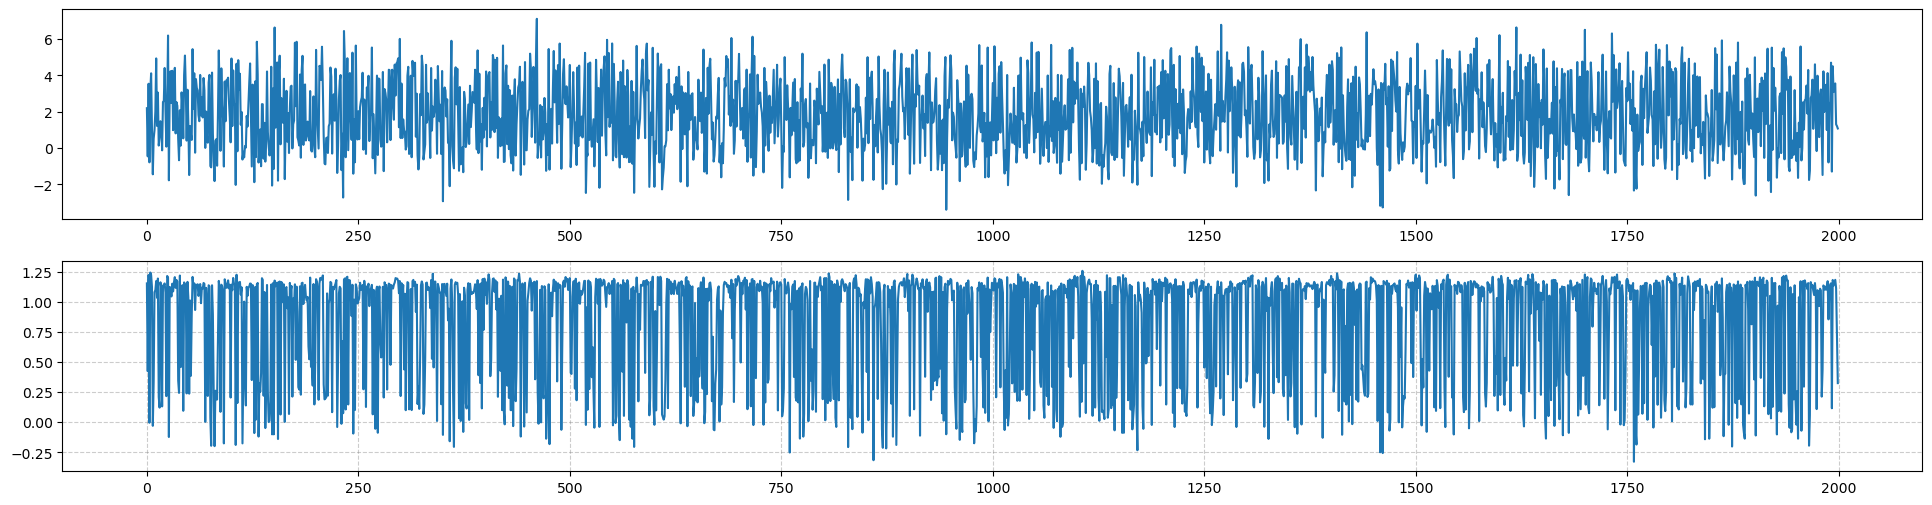

In [2]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize = (24, 6))

ax[0].plot(original_truncated[:, 0])
ax[1].plot(reconstructed[:, 0])
plt.grid(color = "gray", linestyle = "--", alpha = .4)
plt.show()